# 0. Importing libraries

In [1]:
# !pip install wordcloud

In [2]:
# !pip install sentence_transformers

In [3]:
import numpy as np
import pandas as pd

import os
import time
import string

import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sentence_transformers import SentenceTransformer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances

from wordcloud import WordCloud, STOPWORDS

C:\Users\arkur\anaconda3\envs\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Loading data

In [4]:
news_db_raw = pd.read_json("News_Category_Dataset_v3.json", lines=True)

In [5]:
news_db_raw.head()

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


In [6]:
news_db_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209527 entries, 0 to 209526
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   link               209527 non-null  object        
 1   headline           209527 non-null  object        
 2   category           209527 non-null  object        
 3   short_description  209527 non-null  object        
 4   authors            209527 non-null  object        
 5   date               209527 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 9.6+ MB


#  2. Data exploring

Feching only articles since 2020.01.01. This is my arbitrary choice and this doens't change the core of the project

In [7]:
news_db_raw = news_db_raw[news_db_raw['date']>= pd.Timestamp(2020,1,1)]

In [8]:
news_db_raw.head(3)

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23


In [9]:
news_db = news_db_raw.copy()

<b> 2.1 Removing duplicates </b>

In [10]:
news_db = news_db.drop_duplicates('headline', keep = 'first')
print("Total number of articles after removing duplicates:", news_db.shape[0])

Total number of articles after removing duplicates: 5517


In [11]:
print("Amount of all articles : ", news_db.shape[0])
print("Amount of authors :      ", len(news_db['authors'].unique()))
print("Amount of categories :   ", len(news_db['category'].unique()))

Amount of all articles :  5517
Amount of authors :       1097
Amount of categories :    28


<b> 2.2 Looking for NaN values</b>

In [12]:
news_db.isna().sum()

link                 0
headline             0
category             0
short_description    0
authors              0
date                 0
dtype: int64

 <b> 2.3. Exploring category column </b>

In [13]:
news_db['category'].unique()

array(['U.S. NEWS', 'COMEDY', 'PARENTING', 'WORLD NEWS', 'CULTURE & ARTS',
       'TECH', 'SPORTS', 'ENTERTAINMENT', 'POLITICS', 'WEIRD NEWS',
       'ENVIRONMENT', 'EDUCATION', 'CRIME', 'SCIENCE', 'WELLNESS',
       'BUSINESS', 'STYLE & BEAUTY', 'FOOD & DRINK', 'MEDIA',
       'QUEER VOICES', 'HOME & LIVING', 'WOMEN', 'BLACK VOICES', 'TRAVEL',
       'MONEY', 'RELIGION', 'LATINO VOICES', 'IMPACT'], dtype=object)

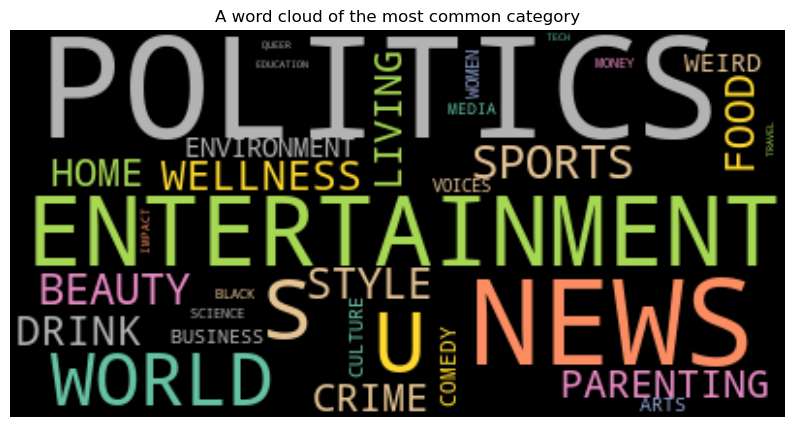

In [14]:
wordcloud = WordCloud(background_color='black', 
                      contour_color='black', 
                      random_state=3, 
                      colormap='Set2',  
                      collocations=False).generate(" ".join(news_db['category']))

plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('A word cloud of the most common category')
plt.axis("off")
plt.show()

Word cloud, also known as a tag cloud, is a visual representation of text data in which words are displayed in varying sizes, with the size of each word indicating its frequency or importance in the given text. 

In [15]:
news_category_df = pd.DataFrame(news_db['category'].value_counts()).reset_index()
news_category_df.rename(columns={'index': 'category',
                                 'count': 'amount'}, inplace=True)

Another representation of category distribution is a bar chart. Values on the top of each bar is the amount of articles in category. The plot shows 10 most commont category. As mentioned before data scope is since 2020.01.01

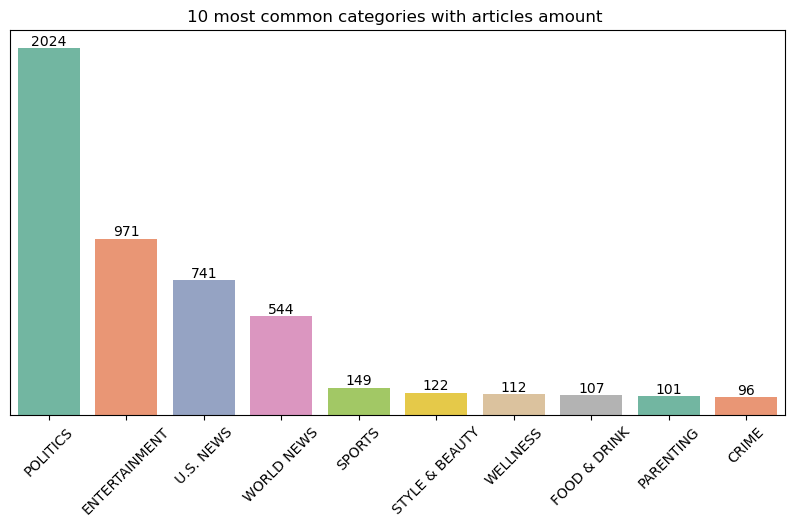

In [16]:
fig, ax = plt.subplots(figsize=(10,5))
style = sns.color_palette("Set2")
ax = sns.barplot(x = news_category_df.category[:10], y = news_category_df.amount[:10], palette=style)
ax.bar_label(ax.containers[0], fontsize=10)
plt.xticks(rotation=45)
ax.set_yticks([])
ax.set_ylabel(None)
ax.set_xlabel(None)
ax.set_title('10 most common categories with articles amount ')
plt.show()

In [17]:
news_db_per_month_df = pd.DataFrame(news_db.resample('m', on = 'date')['headline'].count()).reset_index()
dates_label = news_db_per_month_df['date'].dt.strftime("%b'%y").values

 <b> 2.4. Amount of articles per month </b>

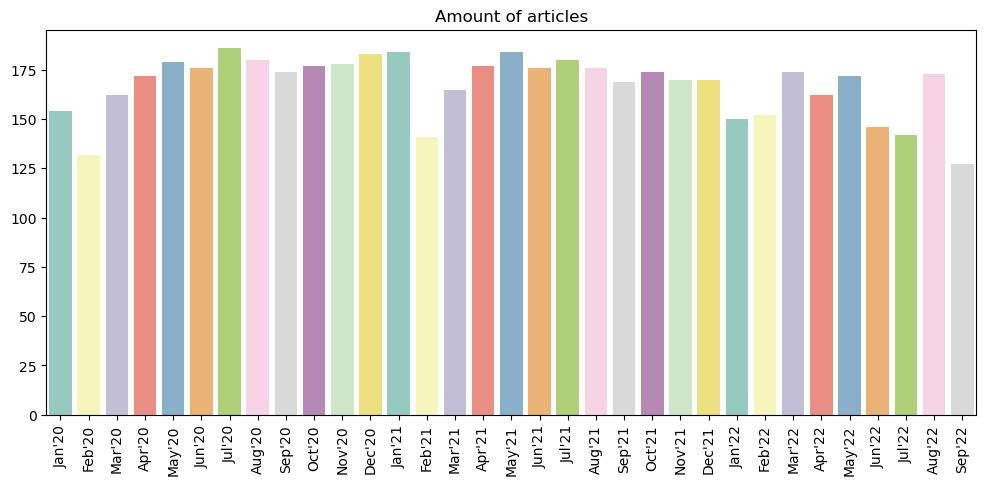

In [18]:
fig, ax = plt.subplots(figsize=(12,5))
style = sns.color_palette("Set3", 12)
ax = sns.barplot(x = news_db_per_month_df.date, y = news_db_per_month_df.headline, palette=style)
ax.set_xticklabels(dates_label)
plt.xticks(rotation='vertical')
ax.set_ylabel(None)
ax.set_xlabel(None)
ax.set_title('Amount of articles')
plt.show()

The most articles were published in July 2020. It doesn't seem to be a rule as in 2021 more articles were published in May and in 2022 in March. Least articles are usually on February which is related to number of days in this month. In 2022 least articles were published in September, becouse articles in our dataset ends on 23.09.2023.

Below I present another word cloud. This time it shows the representatin of words in headlines

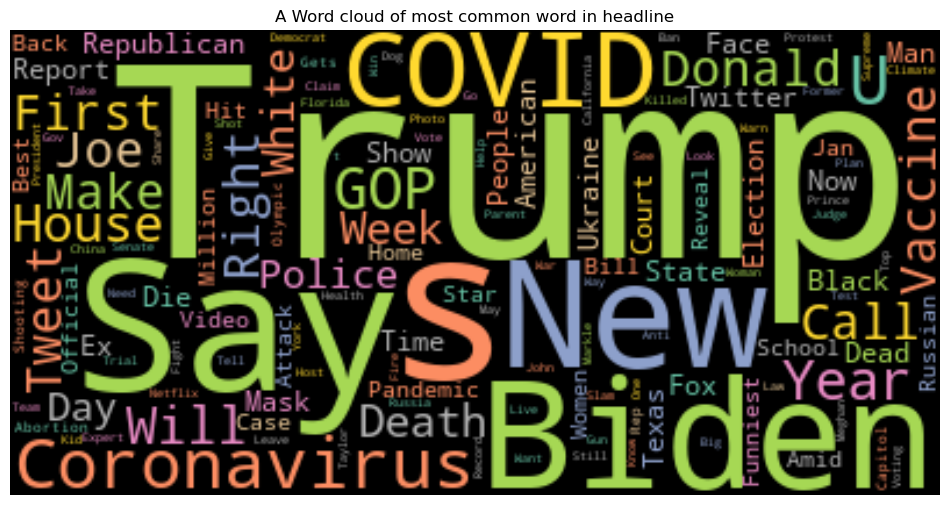

In [19]:
wordcloud = WordCloud(background_color='black', 
                      contour_color='black', 
                      random_state=42, 
                      colormap='Set2',  
                      collocations=False).generate(" ".join(news_db.headline))

plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('A Word cloud of most common word in headline')
plt.show()

 <b> 2.5 A kernel density estimator </b> 

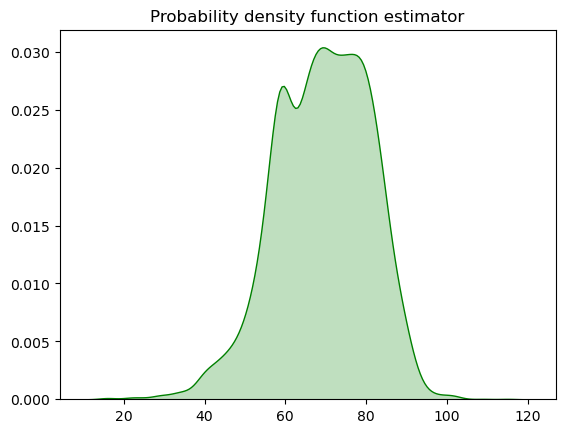

In [20]:
fig, ax = plt.subplots()
ax = sns.kdeplot(data = news_db['headline'].str.len(), color='green', fill=True)
plt.xticks()
ax.set_ylabel(None)
ax.set_xlabel(None)
ax.set_title('Probability density function estimator')


plt.show()

A kernel density estimator (KDE) is a non-parametric statistical method used to estimate the probability density function (PDF) of a continuous random variable. Here, in our data, most of the headline lenght are around 70 words.

# 3. Text preprocessing

<b> 3.1. Removing stopwords, lemantization</b>

In [21]:
stop_words = stopwords.words('english')
all_stops = set(stopwords.words('english')) | set(string.punctuation)
lemmantizer = WordNetLemmatizer()

The goal of function below is to prepare data for similiarity counting process. The idea is to combine two columns: headline and article descroption. Thanks to this algorithm will have more information about specific article. 

In [22]:
def text_preprocessing(df:pd.DataFrame):
    stop_words = stopwords.words('english')
    all_stops = set(stopwords.words('english')) | set(string.punctuation)
    lemmantizer = WordNetLemmatizer()

    temp_df = pd.DataFrame(columns=['combined_desc', 'category'])
    
    for index, row in df.iterrows():
        
        combined_desc = row['headline'].lower() + " "+ row['short_description'].lower()
        tokenized_combined_desc = word_tokenize(combined_desc)
        lemantized_combined_desc = [lemmantizer.lemmatize(word) for word in tokenized_combined_desc]
        stop_words_removed = [word for word in tokenized_combined_desc if word not in all_stops]
        
        temp_df.loc[index] = {
            'combined_desc' : " ".join(stop_words_removed),
            'category' : row['category']
        }
    
    return temp_df

In [23]:
pd.set_option('display.max_colwidth', None)

In [24]:
df_pr = text_preprocessing(news_db)

In [25]:
df_pr.head(3)

,combined_desc,category
0,4 million americans roll sleeves omicron-targeted covid boosters health experts said early predict whether demand would match 171 million doses new boosters u.s. ordered fall,U.S. NEWS
1,american airlines flyer charged banned life punching flight attendant video subdued passengers crew fled back aircraft confrontation according u.s. attorney 's office los angeles,U.S. NEWS
2,23 funniest tweets cats dogs week sept. 17-23 `` dog n't understand could eaten '',COMEDY


# 4. Similiarity

 <b> 4.1. Tfidf Vectorizer </b>

TF-IDF vectorization is a text preprocessing technique used to convert a collection of documents (corpus) into numerical vectors. It is designed to represent the importance of individual terms (words) within each document relative to the entire corpus

In [26]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_headline = tfidf_vectorizer.fit_transform(df_pr['combined_desc'])

In [27]:
def tfidf_func(row_index, num_similar_items):
    num_similar_items +=1
    
    pairwise_dist = pairwise_distances(tfidf_headline,tfidf_headline[row_index])
    mask = np.argsort(pairwise_dist.ravel())[0:num_similar_items]
    
    df = pd.DataFrame({'publish_date': news_db_raw['date'][mask].values,
               'headline':news_db_raw['headline'][mask].values,
                'Category': news_db_raw['category'][mask].values,
                'Similarity with chosen article': pairwise_dist[mask].ravel()})
    
    print("*"*39, 'The chosen article',"*"*39)
    print("headline: ",news_db["headline"][row_index])
    print("category: ",news_db["category"][row_index])
    print("*"*35, 'A list of similar articles',"*"*35)
    
    return df.iloc[1:,]

tfidf_func(888, 10)

*************************************** The chosen article ***************************************
headline:  Jimmy Kimmel Trolls Ted Cruz With X-Rated Reminder About Twitter’s ‘Edit’ News
category:  ENTERTAINMENT
*********************************** A list of similar articles ***********************************


,publish_date,headline,Category,Similarity with chosen article
1,2021-04-09,Jimmy Kimmel Hits Trump With Stark Reminder Of His COVID-19 Denialism From A Year Ago,ENTERTAINMENT,1.177574
2,2021-06-08,Jimmy Kimmel Spots The Donald Trump Quote That Should Be The Title Of His Memoir,ENTERTAINMENT,1.205605
3,2021-01-07,Jimmy Kimmel Calls Out Trump's ‘Scumbag’ Enablers By Name In Scathing Monologue,ENTERTAINMENT,1.205622
4,2021-10-14,Jimmy Kimmel Saddles Sen. Ted Cruz With Chilling Halloween Nicknames,ENTERTAINMENT,1.226116
5,2021-09-09,‘So That’s His Secret’: Jimmy Kimmel Trolls Trump Over Latest Brain Claim,ENTERTAINMENT,1.242924
6,2021-08-12,Stephen Colbert Trolls Sen. Ted Cruz With A Spine-Tingling Crack,ENTERTAINMENT,1.274061
7,2022-01-14,"Kimmel Mocks Ted Cruz, Marjorie Taylor Greene For 'Historically Stupid' Claim",ENTERTAINMENT,1.277878
8,2022-03-29,Ex-Oscars Host Jimmy Kimmel Reveals How He Would’ve Handled Will Smith’s Slap,ENTERTAINMENT,1.281202
9,2021-10-07,Jimmy Kimmel Exposes Fox News' Coronavirus Hypocrisy In Scathing Takedown,ENTERTAINMENT,1.283518
10,2022-03-24,OOPS! Reporters Spot What Sen. Ted Cruz Was Looking At On His Phone During Hearings,POLITICS,1.287791


 <b> 4.2. SentenceTransformer </b>

Sentence transformers uses  models which where trained on all available training data (more than 1 billion training pairs) and are designed as general purpose models.
There are many different pre-trained models which offers different quality,  speed.

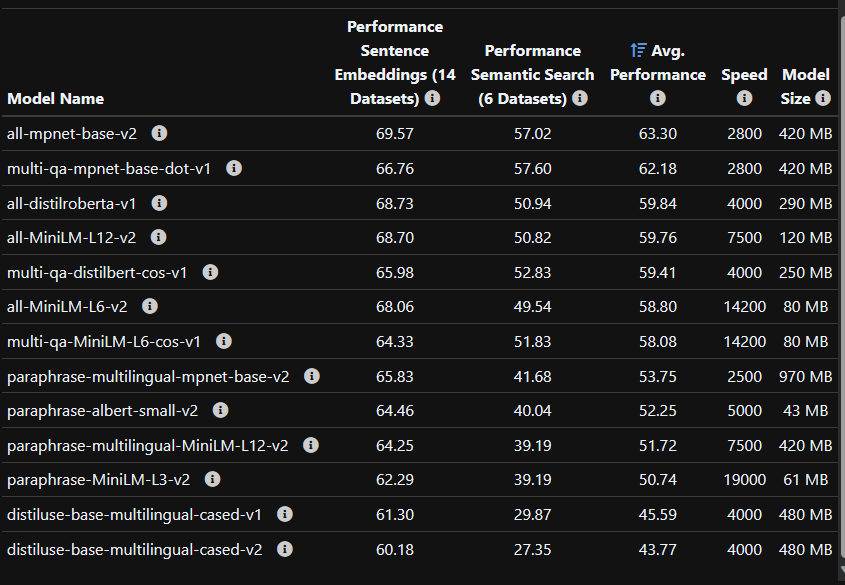


source: https://www.sbert.net/docs/pretrained_mquality

In [28]:
models_list = ['all-MiniLM-L6-v2', 'all-mpnet-base-v2', 'paraphrase-albert-small-v2']
model = SentenceTransformer(models_list[0])

In [29]:
def sentence_trans_func(row_index, num_similar_items):
    
    num_similar_items += 1
    
    chosen_sentence = news_db['headline'][row_index]
    all_sentences = list(news_db['headline'])
    
    sentence_embedding = model.encode(chosen_sentence)
    all_embedding = model.encode(all_sentences)
    
    pairwise_dist = cosine_similarity([sentence_embedding], all_embedding).ravel()
    mask = np.argsort(-pairwise_dist)
    mask = mask[1: num_similar_items]
    
    df = pd.DataFrame({'publish_date': news_db['date'][mask].values,
               'headline':news_db['headline'][mask].values,
                'Category': news_db['category'][mask].values,
                'Similarity with chosen article': pairwise_dist.ravel()[mask]})
    
    print("*"*40, 'The chosen article',"*"*40)
    print("headline: ",news_db["headline"][row_index])
    print("category: ",news_db["category"][row_index])
    print("*"*35, 'A list of similar articles',"*"*35)
        
    return df.iloc[0:,]

In [30]:
sentence_trans_func(888,10)

**************************************** The chosen article ****************************************
headline:  Jimmy Kimmel Trolls Ted Cruz With X-Rated Reminder About Twitter’s ‘Edit’ News
category:  ENTERTAINMENT
*********************************** A list of similar articles ***********************************


,publish_date,headline,Category,Similarity with chosen article
0,2021-09-09,‘So That’s His Secret’: Jimmy Kimmel Trolls Trump Over Latest Brain Claim,ENTERTAINMENT,0.619906
1,2021-05-05,Ted Cruz's Awkward Mar-A-Lago Photo Op With Trump Gets The Treatment On Twitter,POLITICS,0.596677
2,2021-06-03,Ted Cruz Tries A Monty Python Crack And Twitter Users Run Away,POLITICS,0.559805
3,2021-10-14,Jimmy Kimmel Saddles Sen. Ted Cruz With Chilling Halloween Nicknames,ENTERTAINMENT,0.551939
4,2021-11-10,Jimmy Kimmel Taunts ‘Idiot’ Jan. 6 Rioter Who Begged ‘Cult Leader’ Trump For Help,ENTERTAINMENT,0.550268
5,2020-04-01,Jimmy Kimmel Offers Up Some Hilariously Terrible Coronavirus April Fools' Pranks,ENTERTAINMENT,0.539225
6,2021-08-12,Stephen Colbert Trolls Sen. Ted Cruz With A Spine-Tingling Crack,ENTERTAINMENT,0.536913
7,2022-04-20,Jimmy Kimmel Spots Most Embarrassing Moment Yet For Trump's Failing Media Site,ENTERTAINMENT,0.536019
8,2021-04-09,Jimmy Kimmel Hits Trump With Stark Reminder Of His COVID-19 Denialism From A Year Ago,ENTERTAINMENT,0.532614
9,2022-01-26,Trouble For Trump? Jimmy Kimmel Spots An Ominous Sign For The Former President,ENTERTAINMENT,0.521835


#  5. Weighted similarity based on headline and category


Here I add possibility to decide if we want to take into a account the category of the article and we can specify the weights of headline (w1) and category (w2). In this case we take results from tfidf model.

In [31]:
category_ohe = OneHotEncoder()

In [32]:
category_onehot_encoded =category_ohe.fit_transform(np.array(news_db["category"]).reshape(-1,1))

In [33]:
def weighted_results(row_index, num_similar_items, w1=0.8,w2=0.2):
    num_similar_items +=1
    
    pairwise_dist = pairwise_distances(tfidf_headline,tfidf_headline[row_index])
    category_dist = pairwise_distances(category_onehot_encoded, category_onehot_encoded[row_index])
    weighted_result = (w1 *pairwise_dist + w2 * category_dist)/float(w1+w2)
    mask = np.argsort(weighted_result.flatten())[0:num_similar_items].tolist()
    
    df = pd.DataFrame(
    {'published data': news_db["date"][mask].values,
    'headline': news_db["headline"][mask].values,
    'Category': news_db['category'][mask].values,
    'Weighted similarity with chosen article': weighted_result[mask].ravel()
    }
    )
    print("*"*40, 'The chosen article',"*"*40)
    print("headline: ",news_db["headline"][row_index])
    print("category: ",news_db["category"][row_index])
    print("*"*35, 'A list of similar articles',"*"*35)
    
    return df.iloc[1:,]

In [36]:
weighted_results(888,10, w1=0.2, w2=0.8)

**************************************** The chosen article ****************************************
headline:  Jimmy Kimmel Trolls Ted Cruz With X-Rated Reminder About Twitter’s ‘Edit’ News
category:  ENTERTAINMENT
*********************************** A list of similar articles ***********************************


,published data,headline,Category,Weighted similarity with chosen article
1,2021-04-09,Jimmy Kimmel Hits Trump With Stark Reminder Of His COVID-19 Denialism From A Year Ago,ENTERTAINMENT,0.235515
2,2021-06-08,Jimmy Kimmel Spots The Donald Trump Quote That Should Be The Title Of His Memoir,ENTERTAINMENT,0.241121
3,2021-01-07,Jimmy Kimmel Calls Out Trump's ‘Scumbag’ Enablers By Name In Scathing Monologue,ENTERTAINMENT,0.241124
4,2021-10-14,Jimmy Kimmel Saddles Sen. Ted Cruz With Chilling Halloween Nicknames,ENTERTAINMENT,0.245223
5,2021-09-09,‘So That’s His Secret’: Jimmy Kimmel Trolls Trump Over Latest Brain Claim,ENTERTAINMENT,0.248585
6,2021-08-12,Stephen Colbert Trolls Sen. Ted Cruz With A Spine-Tingling Crack,ENTERTAINMENT,0.254812
7,2022-01-14,"Kimmel Mocks Ted Cruz, Marjorie Taylor Greene For 'Historically Stupid' Claim",ENTERTAINMENT,0.255576
8,2022-03-29,Ex-Oscars Host Jimmy Kimmel Reveals How He Would’ve Handled Will Smith’s Slap,ENTERTAINMENT,0.256240
9,2021-10-07,Jimmy Kimmel Exposes Fox News' Coronavirus Hypocrisy In Scathing Takedown,ENTERTAINMENT,0.256704
10,2020-03-26,Jimmy Kimmel Gives Savage New Nickname To Trump In Coronavirus Era,ENTERTAINMENT,0.257846
